<a href="https://colab.research.google.com/github/hongik-machine/Default-Risk-Scoring/blob/feat%2Fnueral-network/Nueral-Network/nueral_network_draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 라이브러리 import, 시드 고정

import os, random, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    precision_recall_fscore_support, confusion_matrix,
    roc_curve, precision_recall_curve
)
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# 재현성: 완전 동일을 보장하진 않지만, 최대한 고정
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TF version:", tf.__version__)

TF version: 2.19.0


In [ ]:
# 파일 업로드
import os

REQUIRED = [
    "X_train_processed_noID.csv",
    "X_test_processed_noID.csv",
    "y_train.csv",
    "y_test.csv",
]

def missing_files():
    return [f for f in REQUIRED if not os.path.exists(f)]

def save_colab_upload(upload_dict):
    """
    Colab files.upload() 반환형: {filename: bytes}
    (간혹 dict형 객체가 올 수도 있어 대비)
    """
    for name, obj in upload_dict.items():
        data = obj if isinstance(obj, (bytes, bytearray)) else obj.get("content", None)
        if data is None:
            raise TypeError(f"Unexpected upload object for {name}: {type(obj)}")
        with open(name, "wb") as w:
            w.write(data)
        print(f"Saved: {name}")

needed = missing_files()
print("필요한 파일:", REQUIRED)
print("현재 누락:", needed if needed else "없음")

if needed:
    try:
        from google.colab import files  # Colab 전용
    except Exception as e:
        raise RuntimeError("이 셀은 Colab 전용입니다. Colab에서 실행해주세요.") from e

# 누락이 사라질 때까지 업로드를 반복
while needed:
    print("\n업로드 창이 뜹니다. 아래 목록 중 '하나'를 선택해서 올리세요:")
    for m in needed: print(" -", m)
    up = files.upload()  # 한 번에 하나만 선택해도 OK. 이 루프가 계속 요청함.
    if not up:
        print("업로드 취소됨. 다시 시도합니다.")
        continue
    save_colab_upload(up)

    needed = missing_files()
    print("남은 누락:", needed if needed else "없음 ")

print("\n모든 필수 CSV가 준비됐습니다.")

필요한 파일: ['X_train_processed_noID.csv', 'X_test_processed_noID.csv', 'y_train.csv', 'y_test.csv']
현재 누락: ['X_train_processed_noID.csv', 'y_train.csv', 'y_test.csv']

업로드 창이 뜹니다. 아래 목록 중 '하나'를 선택해서 올리세요:
 - X_train_processed_noID.csv
 - y_train.csv
 - y_test.csv


Saving X_test_processed_noID.csv to X_test_processed_noID (1).csv
Saved: X_test_processed_noID (1).csv
Renamed: X_test_processed_noID (1).csv → X_test_processed_noID.csv
남은 누락: ['X_train_processed_noID.csv', 'y_train.csv', 'y_test.csv']

업로드 창이 뜹니다. 아래 목록 중 '하나'를 선택해서 올리세요:
 - X_train_processed_noID.csv
 - y_train.csv
 - y_test.csv


Saving X_train_processed_noID.csv to X_train_processed_noID.csv
Saved: X_train_processed_noID.csv
남은 누락: ['y_train.csv', 'y_test.csv']

업로드 창이 뜹니다. 아래 목록 중 '하나'를 선택해서 올리세요:
 - y_train.csv
 - y_test.csv


Saving y_test.csv to y_test.csv
Saved: y_test.csv
남은 누락: ['y_train.csv']

업로드 창이 뜹니다. 아래 목록 중 '하나'를 선택해서 올리세요:
 - y_train.csv


Saving y_train.csv to y_train.csv
Saved: y_train.csv
남은 누락: 없음 

모든 필수 CSV가 준비됐습니다.


In [ ]:
# 데이터 로드 & 정합성 점검

import os
import pandas as pd
import numpy as np

# 파일 경로
X_TR = "X_train_processed_noID.csv"
X_TE = "X_test_processed_noID.csv"
Y_TR = "y_train.csv"
Y_TE = "y_test.csv"
FEATS = "feature_names.txt"   # 선택적 검증용

# 1) 파일 존재 확인
for p in [X_TR, X_TE, Y_TR, Y_TE]:
    if not os.path.exists(p):
        raise FileNotFoundError(f"필수 파일이 없습니다: {p}")

# 2) 로드
X_train = pd.read_csv(X_TR)
X_test  = pd.read_csv(X_TE)
y_train = pd.read_csv(Y_TR).squeeze()
y_test  = pd.read_csv(Y_TE).squeeze()

# 3) 기본 정합성 점검
assert list(X_train.columns) == list(X_test.columns), "Train/Test 컬럼 순서가 다릅니다."
assert len(X_train) == len(y_train), "X_train / y_train 행 수 불일치."
assert len(X_test)  == len(y_test),  "X_test / y_test 행 수 불일치."
assert X_train.isna().sum().sum() == 0 and X_test.isna().sum().sum() == 0, "결측치가 존재합니다."

# 4) (선택) feature_names.txt와 열 이름 대조
if os.path.exists(FEATS):
    with open(FEATS, "r", encoding="utf-8") as f:
        feat_names = [ln.strip() for ln in f if ln.strip()]
    if feat_names:
        if feat_names != list(X_train.columns):
            print(" feature_names.txt와 컬럼 순서/이름이 일부 상이합니다. (학습은 진행 가능)")
        else:
            print(" feature_names.txt와 컬럼이 일치합니다.")

# 5) 분포 출력
print("X_train:", X_train.shape, "| X_test:", X_test.shape)
print("y_train 분포:", y_train.value_counts(normalize=True).round(3).to_dict())
print("y_test  분포:", y_test.value_counts(normalize=True).round(3).to_dict())

# 6) numpy 변환 (TF 입력용)
Xtr = X_train.values.astype("float32")
Xte = X_test.values.astype("float32")
ytr = y_train.values.astype("int32")
yte = y_test.values.astype("int32")
input_dim = Xtr.shape[1]
print("input_dim:", input_dim)

X_train: (22200, 24) | X_test: (7401, 24)
y_train 분포: {0: 0.777, 1: 0.223}
y_test  분포: {0: 0.777, 1: 0.223}
input_dim: 24


In [ ]:
# 클래스 불균형 보정(class_weight) + 검증셋 분리

# 1) 소수 클래스에 더 큰 가중치 부여
classes = np.unique(ytr)
cw = compute_class_weight(class_weight="balanced", classes=classes, y=ytr)
class_weight = {int(k): float(v) for k, v in zip(classes, cw)}
print("class_weight:", class_weight)
# 예: {0: 0.64, 1: 1.98} 이런 형태

# 2) 검증 셋 분리(훈련셋의 20%, 층화 유지)
Xtr_tr, Xtr_val, ytr_tr, ytr_val = train_test_split(
    Xtr, ytr, test_size=0.2, random_state=SEED, stratify=ytr
)
print("train/val shapes:", Xtr_tr.shape, Xtr_val.shape)
print("val 분포:", pd.Series(ytr_val).value_counts(normalize=True).round(3).to_dict())

class_weight: {0: 0.6436275078279021, 1: 2.2406136455389585}
train/val shapes: (17760, 24) (4440, 24)
val 분포: {0: 0.777, 1: 0.223}


In [ ]:
# 모델 구성 함수 (MLP 아키텍처)

def build_mlp(input_dim: int, dropout=0.3, lr=1e-3):
    """
    구조: Dense(128)→BN→ReLU→Dropout → Dense(64)→BN→ReLU→Dropout → Dense(32)→BN→ReLU → Dense(1)→Sigmoid
    - 목적: 비선형 분류 / 과적합 완화 / 수렴 안정
    """
    inp = keras.Input(shape=(input_dim,))
    x = layers.Dense(128, activation=None)(inp)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout)(x)

    x = layers.Dense(64, activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout)(x)

    x = layers.Dense(32, activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    out = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inp, out)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[keras.metrics.AUC(name="auc")]
    )
    return model

model = build_mlp(input_dim, dropout=0.3, lr=1e-3)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,465 (56.50 KB)

 Trainable params: 14,017 (54.75 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# 콜백 설정 & 학습 수행

# 콜백: Plateau 시 학습률 절반, 개선 정체 시 조기종료(검증 AUC 기준)
callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_auc", factor=0.5, patience=2, mode="max", verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_auc", patience=5, mode="max", restore_best_weights=True, verbose=1
    )
]

history = model.fit(
    Xtr_tr, ytr_tr,
    validation_data=(Xtr_val, ytr_val),
    epochs=50,
    batch_size=512,
    class_weight=class_weight,   # 불균형 보정
    callbacks=callbacks,
    verbose=1
)

# (선택) 학습곡선 간단 표시: val_auc 추이
val_auc_hist = history.history.get("val_auc", [])
if val_auc_hist:
    print(f"Best val_auc = {max(val_auc_hist):.4f} @ epoch {np.argmax(val_auc_hist)+1}")

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - auc: 0.6526 - loss: 0.7388 - val_auc: 0.7054 - val_loss: 0.8950 - learning_rate: 0.0010
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7235 - loss: 0.6223 - val_auc: 0.7440 - val_loss: 0.7005 - learning_rate: 0.0010
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.7446 - loss: 0.5954 - val_auc: 0.7615 - val_loss: 0.6509 - learning_rate: 0.0010
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.7430 - loss: 0.5936 - val_auc: 0.7695 - val_loss: 0.6250 - learning_rate: 0.0010
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7607 - loss: 0.5797 - val_auc: 0.7738 - val_loss: 0.6041 - learning_rate: 0.0010
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.7637 - loss: 0.5761 - val_auc: 0.7766 - val_loss: 0.5841 - learning_rate: 0.0010
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.7661 - loss: 0.5729 - val_auc: 0.7777 - val_loss: 0.5730 - learning_rate: 0.0010
Epoch 8/50
35

In [ ]:
# 임계값 튜닝 (검증 F1 최대) & 테스트 평가

# 1) 검증/테스트 확률
p_val = model.predict(Xtr_val, verbose=0).ravel()
p_te  = model.predict(Xte,     verbose=0).ravel()

# 2) 검증 PR-curve로 F1 최대 임계값 탐색
prec, rec, thr = precision_recall_curve(ytr_val, p_val)
# F1 계산(0 divide 방지)
f1s = 2 * (prec*rec) / (prec + rec + 1e-12)
best_idx = np.nanargmax(f1s)
# precision_recall_curve의 thr 길이는 len(points)-1 이므로 인덱스 보정
best_thr = thr[max(best_idx-1, 0)] if best_idx < len(thr) else 0.5

print(f"Best threshold(from val) = {best_thr:.4f} | F1(val) = {np.nanmax(f1s):.4f}")

# 3) 확률 기반 지표(테스트)
roc_auc = roc_auc_score(yte, p_te)
pr_auc  = average_precision_score(yte, p_te)  # AP = PR-AUC
print(f"ROC-AUC(test) = {roc_auc:.4f} | PR-AUC(test) = {pr_auc:.4f}")

# 4) 이진화 후 최종 지표
y_pred = (p_te >= best_thr).astype(int)
P, R, F1, _ = precision_recall_fscore_support(yte, y_pred, average="binary", zero_division=0)
cm = confusion_matrix(yte, y_pred)

print(f"Precision(test) = {P:.4f} | Recall(test) = {R:.4f} | F1(test) = {F1:.4f}")
print("Confusion Matrix:\n", cm)

# 5) (선택) JSON 형태로 결과 저장
results = {
    "threshold": float(best_thr),
    "roc_auc": float(roc_auc),
    "pr_auc": float(pr_auc),
    "precision": float(P),
    "recall": float(R),
    "f1": float(F1),
    "confusion_matrix": cm.tolist()
}
with open("nn_results.json", "w") as f:
    json.dump(results, f, indent=2)
print(" Saved: nn_results.json")

Best threshold(from val) = 0.5427 | F1(val) = 0.5524
ROC-AUC(test) = 0.7730 | PR-AUC(test) = 0.5455
Precision(test) = 0.4946 | Recall(test) = 0.5815 | F1(test) = 0.5345
Confusion Matrix:
 [[4769  981]
 [ 691  960]]
 Saved: nn_results.json


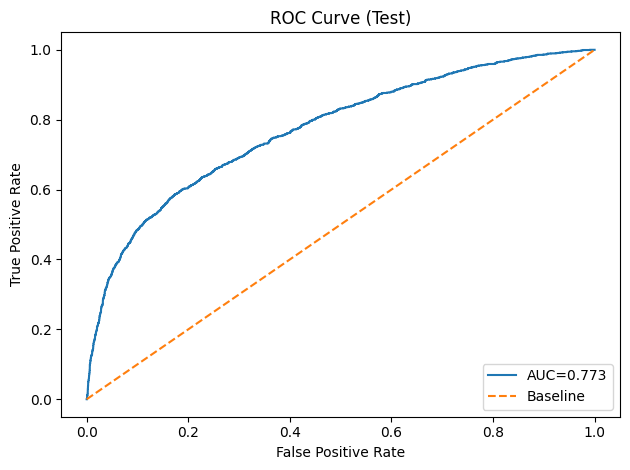

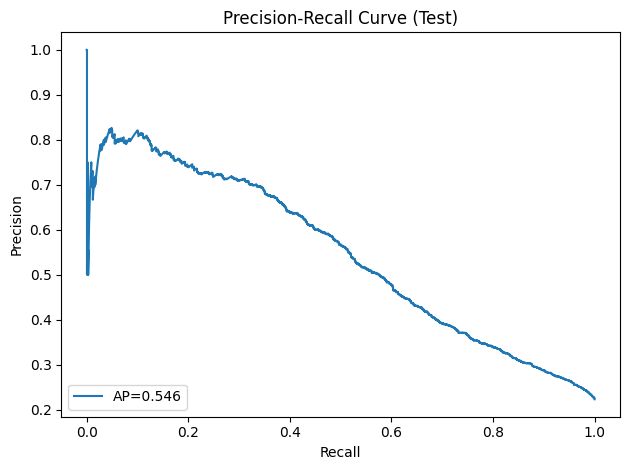

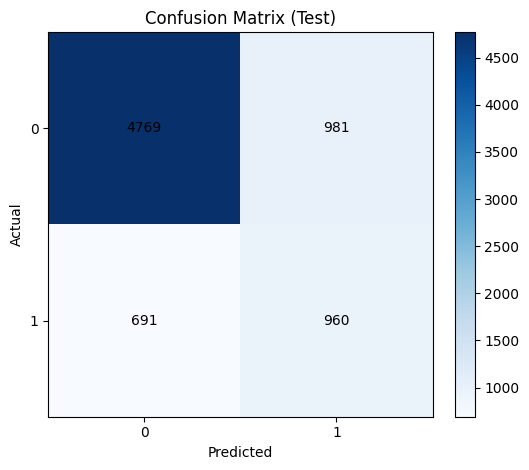

 Saved: roc_curve.png, pr_curve.png, confusion_matrix.png


In [ ]:
# 1) ROC Curve
fpr, tpr, _ = roc_curve(yte, p_te)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--", label="Baseline")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("roc_curve.png", dpi=150)
plt.show()

# 2) Precision-Recall Curve
prec_te, rec_te, _ = precision_recall_curve(yte, p_te)
plt.figure()
plt.plot(rec_te, prec_te, label=f"AP={pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Test)")
plt.legend(loc="lower left")
plt.tight_layout()
plt.savefig("pr_curve.png", dpi=150)
plt.show()

# 3) Confusion Matrix Heatmap
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap="Blues")
ax.set_title("Confusion Matrix (Test)")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(["0","1"]); ax.set_yticklabels(["0","1"])
for (i,j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha='center', va='center')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=150)
plt.show()

print(" Saved: roc_curve.png, pr_curve.png, confusion_matrix.png")

In [ ]:
# === Create & save resampled train sets (SMOTE / ClusterCentroids) ===
!pip -q install imbalanced-learn

import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids

print("원본 train shape:", Xtr.shape, ytr.shape, "| 클래스 분포:", dict(pd.Series(ytr).value_counts()))

# SMOTE (오버샘플링)
sm = SMOTE(random_state=42)
Xs, ys = sm.fit_resample(Xtr, ytr)
np.save("X_train_smote.npy", Xs.astype("float32"))
np.save("y_train_smote.npy", ys.astype("int32"))
print("SMOTE shape:", Xs.shape, "| 분포:", dict(pd.Series(ys).value_counts()))
print("Saved: X_train_smote.npy, y_train_smote.npy")

# Cluster Centroids (언더샘플링)
cc = ClusterCentroids(random_state=42)
Xu, yu = cc.fit_resample(Xtr, ytr)
np.save("X_train_cc.npy", Xu.astype("float32"))
np.save("y_train_cc.npy", yu.astype("int32"))
print("CC shape:", Xu.shape, "| 분포:", dict(pd.Series(yu).value_counts()))
print("Saved: X_train_cc.npy, y_train_cc.npy")


원본 train shape: (22200, 24) (22200,) | 클래스 분포: {0: np.int64(17246), 1: np.int64(4954)}
SMOTE shape: (34492, 24) | 분포: {0: np.int64(17246), 1: np.int64(17246)}
Saved: X_train_smote.npy, y_train_smote.npy
CC shape: (9908, 24) | 분포: {0: np.int64(4954), 1: np.int64(4954)}
Saved: X_train_cc.npy, y_train_cc.npy


In [ ]:
def train_with_array(X, y, note="SMOTE", seed=SEED):
    # 1) 검증 분리(층화)
    X_tr, X_val, y_tr, y_val = train_test_split(
        X, y, test_size=0.2, random_state=seed, stratify=y
    )
    # 2) 모델
    m = build_mlp(X.shape[1], dropout=0.3, lr=1e-3)
    cbs = [
        keras.callbacks.ReduceLROnPlateau(monitor="val_auc", factor=0.5, patience=2, mode="max", verbose=1),
        keras.callbacks.EarlyStopping(monitor="val_auc", patience=5, mode="max", restore_best_weights=True, verbose=1)
    ]
    # 3) 학습 (class_weight는 보통 resample 시 생략)
    m.fit(X_tr, y_tr, validation_data=(X_val, y_val), epochs=50, batch_size=512, callbacks=cbs, verbose=1)

    # 4) 테스트 평가(확률)
    p_te = m.predict(Xte, verbose=0).ravel()
    roc = roc_auc_score(yte, p_te)
    pr  = average_precision_score(yte, p_te)
    print(f"[{note}] ROC-AUC={roc:.4f} | PR-AUC={pr:.4f}")
    return {"note": note, "roc_auc": float(roc), "pr_auc": float(pr)}

compare = []

# SMOTE 버전
if os.path.exists("X_train_smote.npy") and os.path.exists("y_train_smote.npy"):
    Xs = np.load("X_train_smote.npy").astype("float32")
    ys = np.load("y_train_smote.npy").astype("int32")
    compare.append(train_with_array(Xs, ys, note="SMOTE"))

# 언더샘플 버전
if os.path.exists("X_train_cc.npy") and os.path.exists("y_train_cc.npy"):
    Xu = np.load("X_train_cc.npy").astype("float32")
    yu = np.load("y_train_cc.npy").astype("int32")
    compare.append(train_with_array(Xu, yu, note="ClusterCentroids"))

if compare:
    with open("nn_compare.json", "w") as f:
        json.dump(compare, f, indent=2)
    print(" Saved: nn_compare.json")
else:
    print("비교용 리샘플 파일이 없어 Cell 8은 건너뜀.")

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - auc: 0.6406 - loss: 0.7069 - val_auc: 0.7356 - val_loss: 0.6662 - learning_rate: 0.0010
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - auc: 0.7487 - loss: 0.5919 - val_auc: 0.7581 - val_loss: 0.6181 - learning_rate: 0.0010
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - auc: 0.7645 - loss: 0.5779 - val_auc: 0.7714 - val_loss: 0.5884 - learning_rate: 0.0010
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - auc: 0.7704 - loss: 0.5727 - val_auc: 0.7802 - val_loss: 0.5710 - learning_rate: 0.0010
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 0.7725 - loss: 0.5681 - val_auc: 0.7826 - val_loss: 0.5665 - learning_rate: 0.0010
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - auc: 0.7778 - loss: 0.5624 - val_auc: 0.7843 - val_loss: 0.5631 - learning_rate: 0.0010
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - auc: 0.7818 - loss: 0.5607 - val_auc: 0.7862 - val_loss: 0.5582 - learning_rate: 0.0010
Epoch 8/50
5